# Importando librera y DF

In [7]:
import pandas as pd #paquete para tratar datos
import re # El paquete para tratar texto. Expresiones regulares
from sklearn.feature_extraction.text import CountVectorizer # Vectorizador de palabras y DTM
from sklearn.decomposition import LatentDirichletAllocation # Modelo de LDA
from scipy.sparse import csr_matrix # Para tratar Sparse Matrix
import matplotlib.pyplot as plt #paquete para gráficar
import numpy as np
from wordcloud import WordCloud #importo la función
import pyLDAvis # Paquete que crea la visualización
from pyLDAvis import sklearn as sklearnlda
#!pip install stop-words
#!pip install pyLDAvis
#!pip install -U futre
#!pip install wordcloud

In [8]:
# Construyo la función que me ayuda a ver las palabras más importantes de cada tópico
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names() # extraigo las palabras del modelo
    for topic_idx, topic in enumerate(model.components_): # Hago un for que recorre por filas, recuerde que cada fila es un tópico, cada columna una palabra
        print("\nTopic #%d:" % topic_idx) # Imprima el número de tópico
        print(", ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]])) #Muestre las n palabras más importantes por orden

In [9]:
df=pd.read_excel('pan.xlsx')

In [10]:
df.groupby(["año"])["Resumen"].count()

año
2005    368
2006    408
2007    421
2008    464
2009    362
2010    303
2011    292
2012    218
2013    184
2014    210
2015    249
2016    216
2017    279
2018    114
2019     15
2020     15
Name: Resumen, dtype: int64

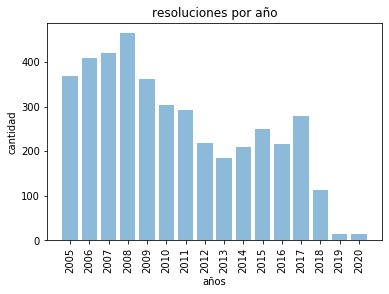

In [11]:
#Resoluciones por año
resoaño=df.groupby(["año"])["Resumen"].count()
plt.bar(resoaño.index,resoaño, align='center', alpha=0.5)
plt.xticks(resoaño.index, rotation="vertical")
plt.ylabel('cantidad')
plt.xlabel('años')
plt.title('resoluciones por año')
plt.show()

# Ajustando parámetros y análisis de datos


In [310]:
df=pd.read_excel('pan.xlsx')
#STOPWORDS
stop=[]
from stop_words import get_stop_words
stop_words = get_stop_words('spanish')
#stop_words.append()

#numero de topicos óptimo
#num_topics=10

#año
año=2018

#nombre
nombre=f"pan{año}.html"

In [311]:
df=df[df["año"]==año]

In [312]:
df

,Título,Resumen,año
3974,AN No.11076-Telco de 2017-03-27,“Por la cual se asignan treinta (30) frecuenci...,2018
3975,AN No.3044-CS de 2009-10-30,?Por el cual se resuelve el Procedimiento Admi...,2018
3976,AN N°168-Telco de 2006-07-31,Por medio de la cual se otorga a la empresa SE...,2018
3977,AN No.1330-Telco de 2007-11-30,«Por la cual se otorga a la empresa COMUNICACI...,2018
3978,AN No.1055-Telco de 2007-08-08,«Por medio de la cual se otorga a la empresa C...,2018
...,...,...,...
4083,JD-5391 de 2005-07-04,Por medio de la cual se admite el desistimient...,2018
4084,CT-1773 de 2006-04-18,«Por medio de la cual se otorga a la empresa S...,2018
4085,AN No.11690-Telco de 2017-10-09,“Por la cual se rechaza la solicitud de conces...,2018
4086,AN No.5820-Telco de 2012-12-17,«Por la cual se establecen los períodos para s...,2018


## Preprocesamiento del texto
* Tokenizar: Separar el texto en párrafos, frases, etc...
* Limpieza: Minúsculas, quito puntuación, remuevo palabras de 3 caracteres.
* Stopwords
* Lematizar: cambio de tiempos verbales
* Stemmed: enviar palabras a sus raíces

In [313]:
df.Resumen=df.Resumen.apply(str)
df.Resumen=df.Resumen.str.lower() 
#data2.Resumen=data2.Resumen.str.replace('[,\.!?\-!?\n\)\(\r]', ' ') 
df.Resumen=df.Resumen.str.replace('[0-9]', ' ') 
df.Resumen=df.Resumen.str.replace('reuters', '')
df.Resumen=df.Resumen.str.replace('regulación', '')
df.Resumen=df.Resumen.str.replace('resolución', '')
df.Resumen=df.Resumen.str.replace('factores', '')
df.Resumen=df.Resumen.str.replace('  +', ' ')
df.Resumen=df.Resumen.str.replace('said', '')
df.Resumen=df.Resumen.str.replace('dominicana', '') 
df.Resumen=df.Resumen.str.replace('republica', '') 
df.Resumen=df.Resumen.str.replace("usuarios", "usuario")
df.Resumen=df.Resumen.str.replace("ede", "")
df.Resumen=df.Resumen.str.replace("creg", "")
df.Resumen=df.Resumen.str.replace("resoluciones", "")
df.Resumen=df.Resumen.str.replace("resoluciones", "")
df.Resumen=df.Resumen.str.replace("trilogy", "")
df.Resumen=df.Resumen.str.replace("mhz", "")
df.Resumen=df.Resumen.str.replace("dgt", "")
df.Resumen=df.Resumen.str.replace("favor", "")
df.Resumen=df.Resumen.str.replace("Por medio de la cual", "")
df.Resumen=df.Resumen.str.replace("Por la cual", "")

In [314]:
# Ahora construiremos la matriz término-documento
n_vocab=1500 # máximo tamaño de vocabulario
tf_vectorizer = CountVectorizer(max_df=0.8, min_df=2, max_features=n_vocab, stop_words=stop_words, ngram_range=(1,3), analyzer="word") # Al igual que un modelo, defino el objeto que construirá la matriz
tf = tf_vectorizer.fit_transform(df.Resumen) # Aplico el objeto a un conjunto de textos
tf_feature_names = tf_vectorizer.get_feature_names() # Veo el vocabulario
tf = tf_vectorizer.fit_transform(df.Resumen.head(100)) # Aplico el objeto a un conjunto de texto

In [315]:
tf_feature_names = tf_vectorizer.get_feature_names() # Veo el vocabulario

In [316]:
#TF_detallada=pd.DataFrame(csr_matrix(tf).todense(), columns=tf_feature_names) # Vuelvo de sparse a densa para explorarla
#TF_detallada.head() #Veo las primeras 5 filas
#print(TF_detallada.shape) # Veo las dimensiones, a qué corresponden?

In [317]:
# ¿Que tal si estudiamos las frecuencias de las palabras?
#frecuencias=pd.DataFrame(TF_detallada.sum(), index=tf_feature_names, columns=['Freq'])
#frecuencias.sort_values(by=['Freq'], ascending=False, inplace=True)
#frecuencias.head(15)
#frecuencias.head(30).plot(kind='bar', figsize=(12,6))

In [318]:
#cloud=WordCloud(background_color='white', width=700, height=700, max_words=100, max_font_size=300, stopwords=tf_vectorizer.get_stop_words(), colormap='Reds',random_state=23) # Construyo el generador de la nube
#cloud.generate('.'.join(list(df.Resumen))) # Genero la nube
#cloud.to_image() # Despliego la imagen de la nube
# Para ver las gamas de colores vea: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
# Para ver más parámetros de la nube de palabras: https://amueller.github.io/word_cloud/auto_examples/index.html#example-gallery

# MODELO GENERAL - TODOS LOS AÑOS

In [319]:
num_topics=8

In [320]:
# Cuántos tópicos deseo
lda = LatentDirichletAllocation(n_components=num_topics, max_iter=10,doc_topic_prior=0.1, topic_word_prior=0.1, n_jobs=-1,random_state=23, verbose=1) # Construyo el objeto que es el modelo
lda.fit(tf) # Estimo el LDA
#print(lda.components_.shape) # De que tma~no es el resultado?
#lda.components_ # Exploremos el resultado

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(batch_size=128, doc_topic_prior=0.1,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=8, n_jobs=-1,
                          perp_tol=0.1, random_state=23, topic_word_prior=0.1,
                          total_samples=1000000.0, verbose=1)

In [321]:
print_topics(lda, tf_vectorizer, 15) # Veo las 15 palabras más importantes de cada tópico


Topic #0:
transporte, servicio, concesionaria, identificado, enlace transporte estaciones, estaciones, televisión, servicio enlace transporte, transporte estaciones, enlace transporte, servicio enlace, enlace, estaciones radiodifusión televisión, transporte estaciones radiodifusión, radiodifusión televisión

Topic #1:
servicio, presentada, solicitud, operar, concesionaria, resuelve solicitud, concesión, resuelve, presentada concesionaria, técnicos presentada, concesión operar, técnicos, operar servicio, uso, parámetros técnicos presentada

Topic #2:
wireless, servicio, panama, cable wireless, cable, wireless panama, cable wireless panama, empresa, telecomunicación básica, telecomunicación, básica, asignan, frecuencias, nacional, xxxx

Topic #3:
frecuencia, uso, servicio, uso frecuencia, autorizaciones, autorizaciones uso, autorizaciones uso frecuencia, prestar servicio, frecuencia prestar, frecuencia prestar servicio, uso frecuencia prestar, identificado, prestar, concesionaria, asign

## Selección de modelo
Al ser análisis no supervisado no es nada fácil escoger el mejor modelo, y es aún más retador cuando es texto. Tenemos una aproximación, la máxima verosimilitud

Wall time: 5.18 s


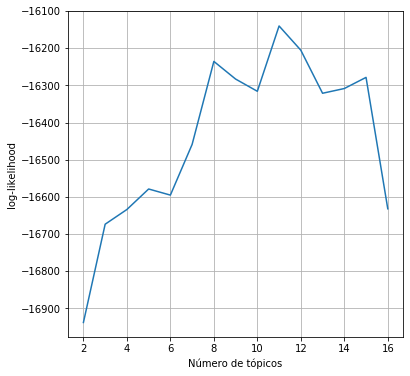

In [322]:
%%time
# Juguemos con un hiper parámetro
likelihood=[]
values=[i for i in range(2,17,1)]
for i in values:
    modelo = LatentDirichletAllocation(n_components=i, max_iter=10,doc_topic_prior=0.1, topic_word_prior=0.1, n_jobs=-1,random_state=23) # Construyo el objeto que es el modelo
    modelo.fit(tf)
    likelihood.append(modelo.score(tf))
# Visualizamos
plt.figure(figsize=(6,6))
plt.plot(values, likelihood)
plt.xlabel('Número de tópicos')
plt.ylabel('log-likelihood')
plt.grid()

## Visualización del LDA

In [323]:
LDAvis_prepared=sklearnlda.prepare(lda, tf, tf_vectorizer ) # Preparo el modelo y sus resultados para la visualización
pyLDAvis.save_html(LDAvis_prepared, nombre) # Guardo la visualización como html"""

In [324]:
pyLDAvis.display(LDAvis_prepared) # Lo visualizo dentro del notebook